In [122]:
# read mat file
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy import sparse
import matplotlib.pyplot as plt
import time
import scipy
import scipy.io
from scipy.signal import butter
from scipy.sparse import spdiags

## 1. Take one data as an example

In [123]:
# load mat file
sample_file = sio.loadmat('./mmpd/p6_0.mat')
print(sample_file.keys())

dict_keys(['__header__', '__version__', '__globals__', 'video', 'GT_ppg', 'light', 'motion', 'exercise', 'skin_color', 'gender', 'glasser', 'hair_cover', 'makeup'])


You can see there are several keys in the data. You will mainly use 'video' and 'GT_ppg' for your evaluation. The 'video' records the stationary scene of the face, and the 'GT_ppg' records the ground truth heart rate of the participants in the video.

In [124]:
video = sample_file['video']
gt = sample_file['GT_ppg']
video.shape, gt.shape

((1800, 80, 60, 3), (1, 1800))

As mentioned in the paper, the sampling rate of the video and ground truth is **30 fps**.

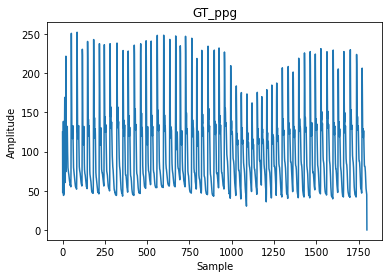

In [125]:
# 绘制gt数组
#gt[0]=gt[0]-np.mean(gt[0])
plt.plot(gt[0])
# 添加标题和标签
plt.title('GT_ppg')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

# 显示图形
plt.show()

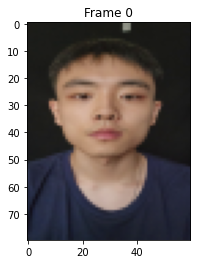

In [126]:
# 定义要打印的前几帧数量
num_frames = 1

# 循环打印每一帧图像
for i in range(num_frames):
    frame = video[i]

    # 使用imshow函数绘制图像
    plt.imshow(frame)

    # 添加标题
    plt.title('Frame {}'.format(i))

    # 显示图像
    plt.show()

# POS

In [127]:
def POS_WANG(frames, fs):
    WinSec = 1.6
    RGB = _process_video(frames)
    N = RGB.shape[0]
    H = np.zeros((1, N))
    l = math.ceil(WinSec * fs)

    for n in range(N):
        m = n - l
        if m >= 0:
            Cn = np.true_divide(RGB[m:n, :], np.mean(RGB[m:n, :], axis=0))
            Cn = np.mat(Cn).H
            S = np.matmul(np.array([[0, 1, -1], [-2, 1, 1]]), Cn)
            h = S[0, :] + (np.std(S[0, :]) / np.std(S[1, :])) * S[1, :]
            mean_h = np.mean(h)
            for temp in range(h.shape[1]):
                h[0, temp] = h[0, temp] - mean_h
            H[0, m:n] = H[0, m:n] + (h[0])

    BVP = H
    BVP = detrend(np.mat(BVP).H, 100)
    BVP = np.asarray(np.transpose(BVP))[0]
    b, a = signal.butter(1, [0.75 / fs * 2, 3 / fs * 2], btype='bandpass')
    BVP = signal.filtfilt(b, a, BVP.astype(np.double))
    return BVP

def _process_video(frames):
    """Calculates the average value of each frame."""
    RGB = []
    for frame in frames:
        summation = np.sum(np.sum(frame, axis=0), axis=0)
        RGB.append(summation / (frame.shape[0] * frame.shape[1]))
    return np.asarray(RGB)

def detrend(input_signal, lambda_value):
    signal_length = input_signal.shape[0]
    # observation matrix
    H = np.identity(signal_length)
    ones = np.ones(signal_length)
    minus_twos = -2 * np.ones(signal_length)
    diags_data = np.array([ones, minus_twos, ones])
    diags_index = np.array([0, 1, 2])
    D = sparse.spdiags(diags_data, diags_index,
                (signal_length - 2), signal_length).toarray()
    filtered_signal = np.dot(
        (H - np.linalg.inv(H + (lambda_value ** 2) * np.dot(D.T, D))), input_signal)
    return filtered_signal

# CHROM

In [128]:
def CHROME_DEHAAN(frames,FS):
    LPF = 0.7
    HPF = 2.5
    WinSec = 1.6

    RGB = process_video(frames)
    FN = RGB.shape[0]
    NyquistF = 1/2*FS
    B, A = signal.butter(3, [LPF/NyquistF, HPF/NyquistF], 'bandpass')

    WinL = math.ceil(WinSec*FS)
    if(WinL % 2):
        WinL = WinL+1
    NWin = math.floor((FN-WinL//2)/(WinL//2))
    WinS = 0
    WinM = int(WinS+WinL//2)
    WinE = WinS+WinL
    totallen = (WinL//2)*(NWin+1)
    S = np.zeros(totallen)

    for i in range(NWin):
        RGBBase = np.mean(RGB[WinS:WinE, :], axis=0)
        RGBNorm = np.zeros((WinE-WinS, 3))
        for temp in range(WinS, WinE):
            RGBNorm[temp-WinS] = np.true_divide(RGB[temp], RGBBase)
        Xs = np.squeeze(3*RGBNorm[:, 0]-2*RGBNorm[:, 1])
        Ys = np.squeeze(1.5*RGBNorm[:, 0]+RGBNorm[:, 1]-1.5*RGBNorm[:, 2])
        Xf = signal.filtfilt(B, A, Xs, axis=0)
        Yf = signal.filtfilt(B, A, Ys)

        Alpha = np.std(Xf) / np.std(Yf)
        SWin = Xf-Alpha*Yf
        SWin = np.multiply(SWin, signal.hanning(WinL))

        temp = SWin[:int(WinL//2)]
        S[WinS:WinM] = S[WinS:WinM] + SWin[:int(WinL//2)]
        S[WinM:WinE] = SWin[int(WinL//2):]
        WinS = WinM
        WinM = WinS+WinL//2
        WinE = WinS+WinL
    BVP = S
    return BVP

def process_video(frames):
    "Calculates the average value of each frame."
    RGB = []
    for frame in frames:
        sum = np.sum(np.sum(frame, axis=0), axis=0)
        RGB.append(sum/(frame.shape[0]*frame.shape[1]))
    return np.asarray(RGB)

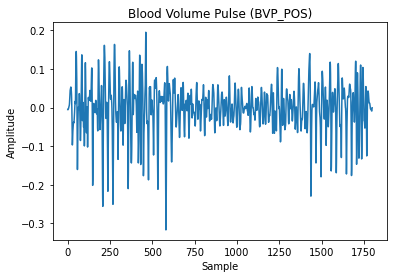

In [129]:
frames = np.array(sample_file['video'])
BVP_POS = POS_WANG(frames, 30)
#BVP_POS = BVP_POS - np.mean(BVP_POS)
# 绘制BVP数组
plt.plot(BVP_POS)

# 添加标题和标签
plt.title('Blood Volume Pulse (BVP_POS)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

# 显示图形
plt.show()

<ipython-input-128-d89e45804147>:33: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  SWin = np.multiply(SWin, signal.hanning(WinL))


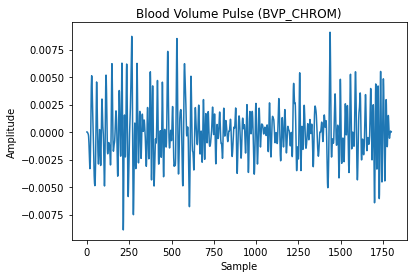

In [130]:
BVP_CHROM = CHROME_DEHAAN(frames, 30)
BVP_CHROM = BVP_CHROM - np.mean(BVP_CHROM)
# 绘制BVP数组
plt.plot(BVP_CHROM)

# 添加标题和标签
plt.title('Blood Volume Pulse (BVP_CHROM)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

# 显示图形
plt.show()

# Calculated BVP

In [201]:
def _calculate_fft_hr(ppg_signal, fs=30, low_pass=0.75, high_pass=2.5):
    """Calculate heart rate based on PPG using Fast Fourier transform (FFT)."""
    ppg_signal = np.expand_dims(ppg_signal, 0)
    N = _next_power_of_2(ppg_signal.shape[1])
    f_ppg, pxx_ppg = scipy.signal.periodogram(ppg_signal, fs=fs, nfft=N, detrend=False)
    fmask_ppg = np.argwhere((f_ppg >= low_pass) & (f_ppg <= high_pass))
    mask_ppg = np.take(f_ppg, fmask_ppg)
    mask_pxx = np.take(pxx_ppg, fmask_ppg)
    fft_hr = np.take(mask_ppg, np.argmax(mask_pxx, 0))[0] * 60
    return fft_hr

# 计算心率值
def _calculate_peak_hr(signal, sampling_rate=30):
    peaks, _ = find_peaks(signal, height=0.5, distance=10)
    heart_rate = len(peaks) / (len(signal) / sampling_rate) * 60
    return heart_rate

def _next_power_of_2(x):
    """Calculate the nearest power of 2."""
    return 1 if x == 0 else 2 ** (x - 1).bit_length()

## PEAK 

Heart Rate: 0.00 bpm


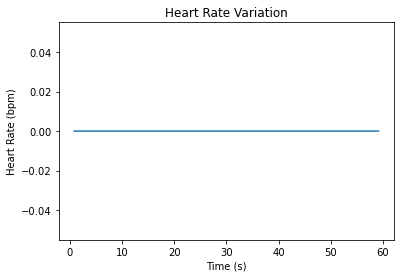

In [205]:
BVP=BVP_POS
window_size=50
sampling_rate=30

heart_rate=_calculate_peak_hr(BVP)

# 打印心率值
print("Heart Rate: {:.2f} bpm".format(heart_rate))

# 滑动窗口计算心率值
heart_rates = []

for i in range(len(BVP) - window_size):
    window = BVP[i:i+window_size]
    heart_rate = _calculate_peak_hr(window)
    heart_rates.append(heart_rate) 

# 绘制折线图
time = np.arange(window_size/2, len(BVP) - window_size/2) / sampling_rate
plt.plot(time, heart_rates)
plt.xlabel('Time (s)')
plt.ylabel('Heart Rate (bpm)')
plt.title('Heart Rate Variation')
plt.show()

heart_rates_peak=heart_rates

## FFT

Heart Rate: 59.77 bpm


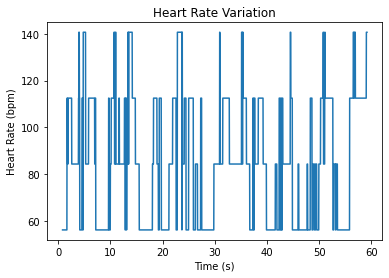

In [202]:
BVP=BVP_POS
window_size=50
sampling_rate=30

heart_rate=_calculate_fft_hr(BVP)

# 打印心率值
print("Heart Rate: {:.2f} bpm".format(heart_rate))

# 滑动窗口计算心率值
heart_rates = []

for i in range(len(BVP) - window_size):
    window = BVP[i:i+window_size]
    heart_rate = _calculate_fft_hr(window)
    heart_rates.append(heart_rate) 

# 绘制折线图
time = np.arange(window_size/2, len(BVP) - window_size/2) / sampling_rate
plt.plot(time, heart_rates)
plt.xlabel('Time (s)')
plt.ylabel('Heart Rate (bpm)')
plt.title('Heart Rate Variation')
plt.show()

heart_rates_fft=heart_rates

# SAMPLE

## PEAK

Heart Rate: 59.00 bpm


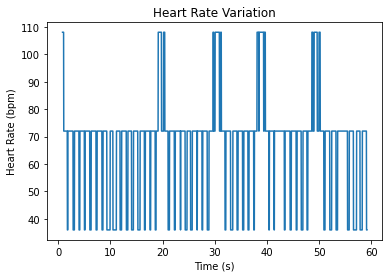

In [204]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

BVP = gt[0]
window_size = 50
sampling_rate = 30

heart_rate = _calculate_peak_hr(BVP)

# 打印心率值
print("Heart Rate: {:.2f} bpm".format(heart_rate))

# 滑动窗口计算心率值
heart_rates = []

for i in range(len(BVP) - window_size):
    window = BVP[i:i+window_size]
    heart_rate = _calculate_peak_hr(window)
    heart_rates.append(heart_rate) 

# 使用线性插值补全断点
heart_rates_interp = np.array(heart_rates)
zero_indices = np.where(heart_rates_interp == 0)[0]

for i in zero_indices:
    if i == 0:
        heart_rates_interp[i] = heart_rates_interp[i+1]
    elif i == len(heart_rates_interp) - 1:
        heart_rates_interp[i] = heart_rates_interp[i-1]
    else:
        heart_rates_interp[i] = (heart_rates_interp[i-1] + heart_rates_interp[i+1]) / 2

# 绘制折线图
time = np.arange(window_size/2, len(BVP) - window_size/2) / sampling_rate
plt.plot(time, heart_rates_interp)
plt.xlabel('Time (s)')
plt.ylabel('Heart Rate (bpm)')
plt.title('Heart Rate Variation')
plt.show()

sample_peak = heart_rates_interp

## FFT 

Heart Rate: 53.61 bpm


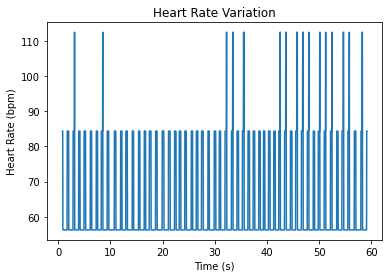

In [191]:
BVP=gt[0]
window_size=50
sampling_rate=30

heart_rate=_calculate_fft_hr(BVP)

# 打印心率值
print("Heart Rate: {:.2f} bpm".format(heart_rate))

# 滑动窗口计算心率值
heart_rates = []

for i in range(len(BVP) - window_size):
    window = BVP[i:i+window_size]
    heart_rate = _calculate_fft_hr(window)
    #print(heart_rate)
    heart_rates.append(heart_rate) 

# 绘制折线图
time = np.arange(window_size/2, len(BVP) - window_size/2) / sampling_rate
plt.plot(time, heart_rates)
plt.xlabel('Time (s)')
plt.ylabel('Heart Rate (bpm)')
plt.title('Heart Rate Variation')
plt.show()

sample_fft=heart_rates

## 2. Evaluation

In [182]:
import os

# Define the directory path
dir_path = './mmpd'

# Loop over all files in the directory
for filename in os.listdir(dir_path):
    # Check if the file is a regular file (not a directory)
    if os.path.isfile(os.path.join(dir_path, filename)):
        # Do something with the file
        print(filename)

p29_0.mat
p29_16.mat
p29_4.mat
p29_8.mat
p6_0.mat
p6_16.mat
p6_4.mat
p6_8.mat


You need to evaluate the performance of your algorithm on the above eight videos. The evaluation metric is the **mean absolute error (MAE)** between the estimated heart rate and the ground truth. The MAE is calculated as follows:
$$
MAE = \frac{1}{N}\sum_{i=1}^{N}|HR_{est}^{(i)} - HR_{gt}^{(i)}|
$$
You can use MAE as your evaluation metric in your report. Other metrics are also welcomed.

In [206]:
# 将列表转换为NumPy数组
array1 = np.array(heart_rates_peak)
array2 = np.array(sample_peak)

# 计算绝对误差
absolute_errors = np.abs(array1 - array2)

# 计算平均绝对误差
mae = np.mean(absolute_errors)

print("PEAK_DETECT Mean Absolute Error:", mae)

# 将列表转换为NumPy数组
array1 = np.array(heart_rates_fft)
array2 = np.array(sample_fft)

# 计算绝对误差
absolute_errors = np.abs(array1 - array2)

# 计算平均绝对误差
mae = np.mean(absolute_errors)

print("FFT Mean Absolute Error:", mae)

PEAK_DETECT Mean Absolute Error: 68.00914285714286
FFT Mean Absolute Error: 26.4375
